In [1]:
import numpy as np
import torch
import copy
from quantization.repvgg_quantized import RepVGGWholeQuant
# from quantization.repvgg_quantized import RepVGGWholeQuant
from repvggplus import create_RepVGGplus_by_name, repvgg_model_convert
import os
from torchsummary import summary
from dataclasses import dataclass

In [2]:

from RepOptimizers.data.dataloader import get_dataloader, get_subnet_dataloader
data_dir = "E:/1_TinyML/tiny/benchmark/training/visual_wake_words/vw_coco2014_96"
image_size = 32
workers = 4
batch_size = 128
from main import get_cifar10_loader
# val_loader = get_subnet_dataloader(data_dir, subset_len=1000, batch_size=batch_size, image_size=image_size, num_workers=workers)
_, val_loader = get_cifar10_loader(batchsize=batch_size, image_size=image_size, num_workers=workers)

device = torch.device('cuda:0')

@torch.no_grad()
def get_accuracy(
  model,
  dataloader,
  extra_preprocess = None
) -> float:
  from tqdm import tqdm
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    if extra_preprocess is not None:
        for preprocess in extra_preprocess:
            inputs = preprocess(inputs)

    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

@dataclass
class ArgumentParser():
    load: str = './trained_models/RepVGG-C1/qformat-cifar10/best_ckpt.pth'
    save: str = "./trained_models/RepVGG-C1/qformat-cifar10/best_ckpt_deploy.pth"
    arch: str = 'RepVGG-C1'

args = ArgumentParser()
train_model = create_RepVGGplus_by_name(args.arch, deploy=False, num_classes=10)


if os.path.isfile(args.load):
    print("=> loading checkpoint '{}'".format(args.load))
    checkpoint = torch.load(args.load)
    if 'state_dict' in checkpoint:
        checkpoint = checkpoint['state_dict']
    elif 'model' in checkpoint:
        checkpoint = checkpoint['model']
    ckpt = {k.replace('module.', ''): v for k, v in checkpoint.items()}  # strip the names
    print(ckpt.keys())
    train_model.load_state_dict(ckpt)
else:
    print("=> no checkpoint found at '{}'".format(args.load))

if 'plus' in args.arch:
    train_model.switch_repvggplus_to_deploy()
    torch.save(train_model.state_dict(), args.save)
else:
    pass
    train_model = repvgg_model_convert(train_model, save_path=args.save)
    
    
test_input = torch.randn(1, 3, 32, 32)
train_model(test_input)
train_model = train_model.to(device)
get_accuracy(train_model, val_loader)


=> loading cifar10 data...
Files already downloaded and verified
Files already downloaded and verified
=================== Building the vanila RepVGG ===================
=> loading checkpoint './trained_models/RepVGG-C1/qformat-cifar10/best_ckpt.pth'
dict_keys(['stage0.rbr_dense.conv.weight', 'stage0.rbr_dense.conv.input_param.frac_bit', 'stage0.rbr_dense.conv.input_param.min', 'stage0.rbr_dense.conv.input_param.max', 'stage0.rbr_dense.conv.weight_param.frac_bit', 'stage0.rbr_dense.conv.weight_param.min', 'stage0.rbr_dense.conv.weight_param.max', 'stage0.rbr_dense.conv.output_param.frac_bit', 'stage0.rbr_dense.conv.output_param.min', 'stage0.rbr_dense.conv.output_param.max', 'stage0.rbr_dense.bn.weight', 'stage0.rbr_dense.bn.bias', 'stage0.rbr_dense.bn.running_mean', 'stage0.rbr_dense.bn.running_var', 'stage0.rbr_dense.bn.num_batches_tracked', 'stage0.rbr_1x1.conv.weight', 'stage0.rbr_1x1.conv.input_param.frac_bit', 'stage0.rbr_1x1.conv.input_param.min', 'stage0.rbr_1x1.conv.input_para

77.98999786376953

In [13]:
summary(train_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           QConv2d-1           [-1, 16, 16, 16]             448
          Identity-2           [-1, 16, 16, 16]               0
 HistogramObserver-3           [-1, 16, 16, 16]               0
             ReLU6-4           [-1, 16, 16, 16]               0
       RepVGGBlock-5           [-1, 16, 16, 16]               0
           QConv2d-6             [-1, 16, 8, 8]           2,320
          Identity-7             [-1, 16, 8, 8]               0
 HistogramObserver-8             [-1, 16, 8, 8]               0
             ReLU6-9             [-1, 16, 8, 8]               0
      RepVGGBlock-10             [-1, 16, 8, 8]               0
          QConv2d-11             [-1, 32, 4, 4]           4,640
         Identity-12             [-1, 32, 4, 4]               0
HistogramObserver-13             [-1, 32, 4, 4]               0
            ReLU6-14             [-1, 3

In [14]:

q_model = RepVGGWholeQuant(train_model, quantlayers='all')
q_model.eval()
q_model.prepare_quant()

c:\Users\hci-lab01\.conda\envs\lab\lib\site-packages\torch\ao\quantization\observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [15]:

test_input = torch.randn(1, 3, 96, 96).to(device)
q_model.to(device)
q_model(test_input)


tensor([[ 0.3001, -0.3451,  0.7035,  0.2870, -0.2233, -0.4190,  0.8211,  0.1885,
         -0.8911, -0.6228]], device='cuda:0', grad_fn=<FakeQuantizeBackward>)

In [16]:
q_model

RepVGGWholeQuant(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver(min_val=-4.03135347366333, max_val=3.9394402503967285)
  )
  (stage0): RepVGGBlock(
    (rbr_reparam): QConv2d(
      3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
      (input_param): QParam()
      (weight_param): QParam()
      (bias_param): QParam()
      (output_param): QParam()
    )
    (nonlinearity): ReLU6(
      (activation_post_process): HistogramObserver(min_val=0.0, max_val=6.0)
    )
    (se): Identity()
  )
  (stage1): Sequential(
    (0): RepVGGBlock(
      (rbr_reparam): QConv2d(
        16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        (input_param): QParam()
        (weight_param): QParam()
        (bias_param): QParam()
        (output_param): QParam()
      )
      (nonlinearity): ReLU6(
        (activation_post_process): HistogramObserver(min_val=0.0, max_val=6.0)
      )
      (se): Identity()
    )
  )
  (stage2): Sequential(
    (0): RepVGGBlock(


In [7]:


qmodel = q_model.to(device)

#Calibrate the model
cnt = 0
with torch.no_grad():
  for img, label in val_loader:
    img = img.to(device)
    label = label.to(device)
    if cnt > 10:
        break
    cnt += 1
    qmodel(img)

In [8]:
get_accuracy(qmodel, val_loader)

77.98999786376953

In [9]:
qmodel

RepVGGWholeQuant(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver(min_val=-3.6263318061828613, max_val=3.9404337406158447)
  )
  (stage0): RepVGGBlock(
    (rbr_reparam): QConv2d(
      3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
      (input_param): QParam()
      (weight_param): QParam()
      (bias_param): QParam()
      (output_param): QParam()
    )
    (nonlinearity): ReLU6(
      (activation_post_process): HistogramObserver(min_val=0.0, max_val=6.0)
    )
    (se): Identity()
  )
  (stage1): Sequential(
    (0): RepVGGBlock(
      (rbr_reparam): QConv2d(
        16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        (input_param): QParam()
        (weight_param): QParam()
        (bias_param): QParam()
        (output_param): QParam()
      )
      (nonlinearity): ReLU6(
        (activation_post_process): HistogramObserver(min_val=0.0, max_val=6.0)
      )
      (se): Identity()
    )
  )
  (stage2): Sequential(
    (0): RepVGGBlock

In [10]:
# qmodel = repvgg_model_convert(qmodel, save_path=None)

In [11]:
import matplotlib.pyplot as plt
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

(array([0.00421847, 0.        , 0.        , 0.00421847, 0.        ,
        0.        , 0.00421847, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00421847, 0.        , 0.        , 0.        , 0.00421847,
        0.        , 0.        , 0.        , 0.00421847, 0.        ,
        0.        , 0.00421847, 0.00421847, 0.        , 0.00421847,
        0.00421847, 0.        , 0.        , 0.01265542, 0.00421847,
        0.00843695, 0.00421847, 0.00421847, 0.        , 0.00843692,
        0.00421847, 0.        , 0.00843695, 0.        , 0.01265542,
        0.01265542, 0.01265538, 0.01265542, 0.01265542, 0.00843695,
        0.00421847, 0.00421847, 0.00843695, 0.01265538, 0.00421847,
        0.00421847, 0.00421847, 0.00421847, 0.        , 0.00421847,
        0.00421847, 0.0168739 , 0.02109233, 0.0168739 , 0.01265542,
        0.02952927, 0.0168739 , 0.00843695, 0.02109237, 0.02109233,
        0.02109237, 0.03374779, 0.01687388, 0.01

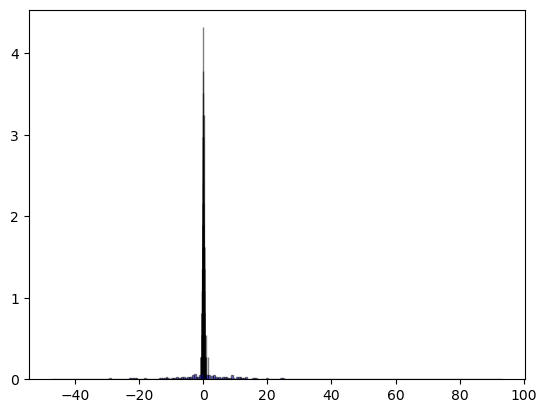

In [12]:
left = qmodel.stage0.rbr_reparam.weight_param.frac_bit.cpu().type(torch.int8)

f_weight = qmodel.stage0.rbr_reparam.weight.detach().cpu().numpy()
# plot_weight_distribution(qmodel, bitwidth=32) 
# sample_fweight = weight[0, :, :, :].detach().cpu().numpy().flatten()

# i_weight = (qmodel.stage0.rbr_reparam.weight * torch.pow(2, left)).detach().cpu().numpy().astype(np.int8)
sample_iweight = (qmodel.stage0.rbr_reparam.weight.detach().cpu().numpy())* (1 << left.cpu().numpy()).astype(np.int8)
plt.hist(f_weight.flatten(), bins=256, density=True, color='red', alpha=0.5, edgecolor='black')
plt.hist(sample_iweight.flatten(), bins=256, density=True, color='blue', alpha=0.5, edgecolor='black')

# plot_weight_distribution(qmodel, bitwidth=8)
